# ABSTRACT

# Business Problem

Earthquakes happen unexpectedly and sometimes, violently. We normally don't think about it in our daily lives, but we always do after the destruction. There are laws to help mitigate the damage of earthquakes, especially in areas with many titonic plates, but now we can take action to mitigate those damages before hand, through the power of data

The Nepalese government wants to find out how to minimalize destruction. Using data collected from the Nepal Earthquake in 2015, build a predictive model to correctly classify how much damage a building will have based on its characteristics.

From there, identify common features with buildings that were "destruction_grade 3" to then reinforce certain areas of the home.

### Chosen Metric: Accuracy

Because we are building a predictor for potentially remodeling some buildings, having false positives will be extremely expensive, and we definately do not want to miss false negatives as that could potentionally put lives at risk. Accuracy is a metric that is a combination of recall and precision.

We also found some class imbalance in our target variable, at about a 67 / 33 split. While it is not the perfect 50 / 50 split we would like, there should be enough data at this split to build a sufficient model.

## Data Understanding

### Imports

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

## Loading The Data

In [42]:
df = pd.read_csv('data/major_damage.csv', index_col = 'building_id')
df_values = df.drop('damage_grade', axis = 1)
df_labels = df[['damage_grade']]

### Display of the first 5 rows of what X_train data will look like

In [30]:
df_values.head()

,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
building_id,,,,,,,,,,,,,,,,,,,
802906,30,6,5,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
28830,10,8,7,3,1,1,2,1,0,1,0,0,0,0,0,0,0,0,0
94947,10,5,5,1,1,1,1,2,0,1,0,0,0,0,0,0,0,0,0
590882,10,6,5,1,1,1,1,2,0,1,0,0,0,0,1,1,0,0,0
201944,30,8,9,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0


### Display of the first 5 rows of what y_train data will look like

In [7]:
df_labels.head()

,damage_grade
building_id,
802906,1
28830,0
94947,1
590882,0
201944,1


## Data Preparation

We split the data into train-test splits here so we can easily pass them straight into the models for testing later.

In [43]:
# Create our train_test split
X_train, X_test, y_train, y_test = train_test_split(df_values, df_labels)

Since this data was provided to us by a competition on DrivenData on creating the best predictor, they had already cleaned the data for us, so all we have to do is transform the data so our model will be able to read it.

For that, we decided to use sklearn's OneHotEncoder class.

In [44]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(X_train)

OneHotEncoder(handle_unknown='ignore')

In [45]:
# Get dummy variables for our object columns for modeling
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Baseline - KNN

Create GridSearchCV using knn pipeline and param testing.

In [18]:
# Create a pipeline to find best parameters
# Pass in 'with_mean = False' because OneHotEncoder transformed our X_train into a sparse matrix
knn_pipe = make_pipeline(StandardScaler(with_mean = False), 
                     KNeighborsClassifier())
knn_pipe

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [19]:
# Test various parameters with grid_search and cross validate the data
params = [{'kneighborsclassifier__n_neighbors': [3, 5],
         'kneighborsclassifier__weights': ['uniform', 'distance'],
         'kneighborsclassifier__leaf_size': [15, 20]}]
gs_knn = GridSearchCV(knn_pipe, param_grid=params, cv=5)

In [22]:
# Runtime: 2 Hours and 50 Minutes
gs_knn.fit(X_train, y_train.values.ravel())

# Print our best paramters
gs_knn.best_params_

{'kneighborsclassifier__leaf_size': 15,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__weights': 'distance'}

In [23]:
# Print our the cross validation test scores
gs_knn.cv_results_['mean_test_score']

array([0.63589671])

In [24]:
# Test for F1 score
y_pred_knn = gs_knn.predict(X_test)
accuracy_score(y_test, y_pred_knn)

0.6402904544959805

#### Because this model took nearly 3 hours to run, this is the baseline model that I hope to beat with different estimators.

# Logistic Regression

In [83]:
# Create a pipeline to find best parameters
# Pass in 'with_mean = False' for StandardScaler because OneHotEncoder transformed our X_train into a sparse matrix
pipe = make_pipeline(StandardScaler(with_mean = False), 
                     LogisticRegression(random_state=42))
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(random_state=42))])

In [84]:
# Test for F1 score
y_pred_log = pipe.predict(X_test)
accuracy_score(y_test, y_pred_log)

0.6645623746365431

In [74]:
f1_score(y_test, y_pred_log)

0.13127692989167639

#### Logistic Regression took less than 1 second to run and even gave us a better metric score. 

# Random Forest Classifer

In [52]:
# Create a pipeline to find best parameters
# Pass in 'with_mean = False' because OneHotEncoder transformed our X_train into a sparse matrix
pipe = make_pipeline(StandardScaler(with_mean = False), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [53]:
# Test various parameters with grid_search and cross validate the data
param_grid = {'randomforestclassifier__n_estimators': [100, 150],
              'randomforestclassifier__min_samples_leaf': [5, 10]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [54]:
# Fit the estimator
gs.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=2018))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [5],
                         'randomforestclassifier__n_estimators': [150]})

In [55]:
# Print our best paramters
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 150}

In [56]:
# Print our the cross validation test scores
gs.cv_results_['mean_test_score']

array([0.68017539])

In [69]:
# Test for accuracy score
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.6823192822601962

In [70]:
f1_score(y_test, y_pred)

0.2439962997224792

#### The Decision Tree Classifier ended up giving us the best F1_score of 68%. This suggests that the Decision Tree Classifier, with some parameter tuning, could yield the best possible model.

In [58]:
param_grid = {'randomforestclassifier__n_estimators': [150, 200, 250],
              'randomforestclassifier__min_samples_leaf': [3, 4, 5, 6, 7]}
gs = GridSearchCV(pipe, param_grid, cv=5)
gs.fit(X_train, y_train.values.ravel())
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 250}

In [75]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.6823192822601962

In [76]:
f1_score(y_test, y_pred)

0.2439962997224792

#### It seems to favor a high number of estimators mixed with a small min samples leaf, up next are parameters to better zone in on the best accuracy rate.


In [60]:
param_grid = {'randomforestclassifier__n_estimators': [250, 300, 350, 400],
              'randomforestclassifier__min_samples_leaf': [3]}
gs = GridSearchCV(pipe, param_grid, cv=5)
gs.fit(X_train, y_train.values.ravel())
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__n_estimators': 300}

In [67]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.6823192822601962

In [68]:
f1_score(y_test, y_pred)

0.2439962997224792

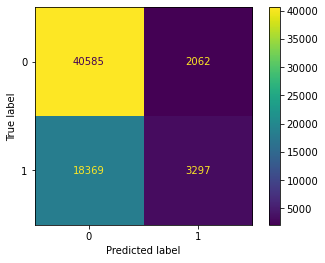

In [64]:
plot_confusion_matrix(gs, X_test, y_test);

In [79]:
# import time
# #Random Forest
# rf = RandomForestClassifier(max_features = None,
#                             max_depth = 45,
#                             min_samples_split = 3,
#                             min_samples_leaf = 30,
#                             random_state=42)
# start_time = time.time()
# model = rf.fit(X_train, y_train)
# rf_time_fit = time.time() - start_time

# #Predictions - Decision Tree
# start_time = time.time()
# model.predict(X_test)
# rf_time_pred = time.time() - start_time
# print("Random Forest")
# print("Fit Time: {} seconds".format(rf_time_fit))
# print("Prediction Time: {} seconds".format(rf_time_pred))
# print("Training Score: {}".format(rf.score(X_train, y_train)))
# print("Test Score: {}".format(rf.score(X_test, y_test)))

In [80]:
# y_pred = rf.predict(X_test)
# accuracy_score(y_test, y_pred)

We could spend longer finding different parameters, but the model's accuracy seems content at around 68.2%.

# Evaluation

Because our business problem has no bias against false negatives / false positives, the accuracy score metric determined that the Random Forest Classifier is the best model with a score of 68%.

The benefits of the Random Forest Classifier is the explainability of the model, meaning we can determine the most important features necessary for prediction. For more information on how we determined the most important features, check out our data_viz notebook!

# Data Limitations

Because the data was collected in Nepal, 2015, the application for the model may be difficult to find. In order to use this model for prediction, the features of the buildings in the new estimating area has to be somewhat similar to that of buildings in Nepal. With the data being 6 years old, it is also possible many potential dangers have been fixed.

# Conclusion



Because earthquakes can be sudden and violent, it is imperative that areas in risk of an earthquake, prepare before it is too late. With the help of our model, with an  68.2% accuracy, we can determine help point regulators to buildings that could be buildings that is in risk of destruction come a major earthquake.